In [1]:
!pip install pykalman
import pandas as pd
import numpy as np
import scipy as sp
import sympy as sm
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime

In [2]:
Ticker1 = "GDX"
Ticker2 = "GLD"
start ="2018-01-01" 
end="2023-01-01"
y1 = yf.download(Ticker1, start, end, interval="1d")["Adj Close"]
y2 = yf.download(Ticker2, start, end, interval="1d")["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
print(Ticker1)
print(y1)


GDX
Date
2018-01-02    22.620508
2018-01-03    22.383099
2018-01-04    22.525543
2018-01-05    22.478064
2018-01-08    22.240654
                ...    
2022-12-23    28.870001
2022-12-27    29.600000
2022-12-28    28.680000
2022-12-29    28.820000
2022-12-30    28.660000
Name: Adj Close, Length: 1259, dtype: float64


In [4]:
print(Ticker2)
print(y2)


GLD
Date
2018-01-02    125.150002
2018-01-03    124.820000
2018-01-04    125.459999
2018-01-05    125.330002
2018-01-08    125.309998
                 ...    
2022-12-23    167.259995
2022-12-27    168.669998
2022-12-28    167.910004
2022-12-29    168.850006
2022-12-30    169.639999
Name: Adj Close, Length: 1259, dtype: float64


In [5]:
np.corrcoef(y1,y2)

array([[1.        , 0.92652673],
       [0.92652673, 1.        ]])

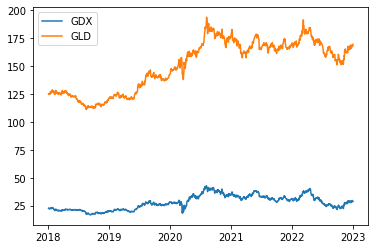

In [6]:
plt.plot(y1, label = Ticker1)
plt.plot(y2, label = Ticker2)
plt.legend()
plt.show()

In [7]:
y1_train=y1[:1007]
y2_train=y2[:1007]
X = sm.add_constant(y2_train)
model = sm.OLS(y1_train,X)
model = model.fit()
beta = model.params[1]
print(model.params[1])
model.params

0.2807350287547345


C:\Users\Prishal\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const       -13.723643
Adj Close     0.280735
dtype: float64

In [8]:
spread = y1-y2*model.params[1]-model.params[0]

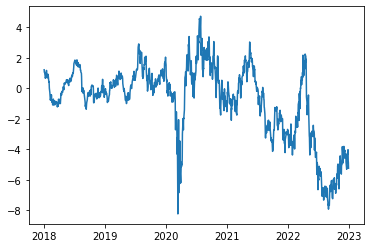

In [9]:
plt.plot(spread)
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller as adf
print(adf(spread[:1007]))
print(adf(spread[:1007])[0])
adf(spread[:1007])[4]

(-3.380006014603722, 0.011659644497148949, 2, 1004, {'1%': -3.436879978012783, '5%': -2.86442302475405, '10%': -2.568305057578451}, 1193.8962491390078)
-3.380006014603722


{'1%': -3.436879978012783, '5%': -2.86442302475405, '10%': -2.568305057578451}

# Dynamic Hedge Ratio


# Rolling Regression

In [11]:
from statsmodels.regression.rolling import RollingOLS

In [12]:
window = 20

In [13]:
X = sm.add_constant(y2)
roll_mod= RollingOLS(y1,X,window)
roll_mod = roll_mod.fit()

C:\Users\Prishal\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [14]:
dynamic_beta = roll_mod.params["Adj Close"]
dynamic_beta

Date
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-08         NaN
                ...   
2022-12-23    0.278005
2022-12-27    0.248458
2022-12-28    0.235158
2022-12-29    0.236834
2022-12-30    0.186685
Name: Adj Close, Length: 1259, dtype: float64

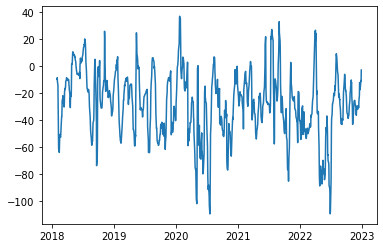

In [15]:

spread2= y1-y2*dynamic_beta

plt.plot(spread2)

In [16]:
'''
Carrying Out an ADF test on the training data to test for stationarity 
'''
spread2_train=spread2[:1007].dropna()
print("The ADF test statistic is "+str(adf(spread2_train)[0]))
print("The significance values are:")
print(adf(spread2_train)[4])


The ADF test statistic is -7.481073740208306
The significance values are:
{'1%': -3.4370062675076807, '5%': -2.8644787205542492, '10%': -2.568334722615888}


# Kalman Filter 

In [17]:
from pykalman import KalmanFilter
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = np.vstack([y2, np.ones(y2.shape)]).T[:, np.newaxis]
    
kf = KalmanFilter(n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1,
        transition_covariance=trans_cov
    )
    
state_means, state_covs = kf.filter(y1)

Text(0.5, 1.0, 'KF slope')

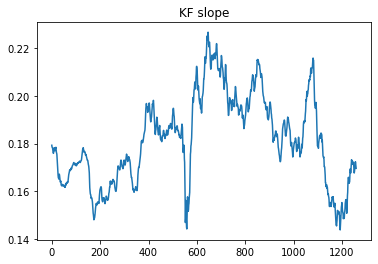

In [18]:
plt.plot(state_means[:,0])
plt.title("KF slope")

Text(0.5, 1.0, 'KF intercept')

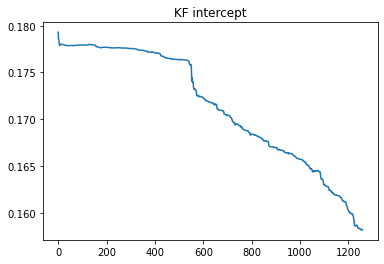

In [19]:
plt.plot(state_means[:,1])
plt.title("KF intercept")


In [20]:
np.matmul(np.transpose(obs_mat[0]),obs_mat[0])

array([[1.56625229e+04, 1.25150002e+02],
       [1.25150002e+02, 1.00000000e+00]])

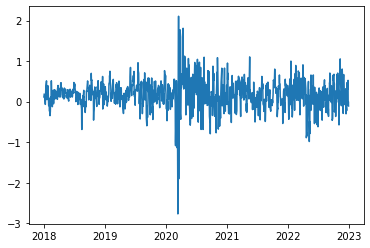

In [21]:
beta_kf = state_means[:,0]
inter_kf = state_means[:,1]
spread_kf = y1-beta_kf*y2
plt.plot(spread_kf)

In [22]:
observation_covariance=1
Q=np.zeros(len(spread_kf))
for i in range(len(spread_kf)):
    Q[i]= np.matmul(np.matmul(obs_mat[i],state_covs[i]),np.transpose(obs_mat[i]))+observation_covariance
sqrt_Q = np.sqrt(Q)
print(Q) #Measurement Variances
print(sqrt_Q)

[1.99993717 1.53499712 1.41102787 ... 1.40810681 1.41100431 1.4126802 ]
[1.41419135 1.23895001 1.18786694 ... 1.18663676 1.18785702 1.18856224]


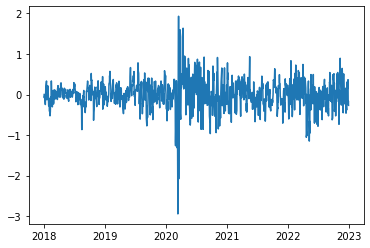

In [23]:
error = y1-beta_kf*y2-inter_kf
plt.plot(error)

In [24]:
spread_kf_train=spread_kf[:1007]
print("The ADF test statistic is "+str(adf(spread_kf_train)[0]))
print("The significance values are:")
print(adf(spread_kf_train)[4])


The ADF test statistic is -18.118624313198254
The significance values are:
{'1%': -3.436866962597422, '5%': -2.864417284603703, '10%': -2.5683020002450507}


In [25]:
#Bollinger Band signal for the Rolling Regression
def Signal_BB(data):
    spreads = data
    signal = []
    rolling_mean = spreads.rolling(window).mean()
    rolling_std = spreads.rolling(window).std()
    for i in range(window):
        signal.append(0)
    for i in range(window,len(spreads)):
        if (spreads[i] > rolling_mean[i]+3*rolling_std[i])or (spreads[i] < rolling_mean[i]-3*rolling_std[i]):
             signal.append(0)
        elif (spreads[i] > rolling_mean[i]+2*rolling_std[i]):
                signal.append(-1)
        
        elif spreads[i] < rolling_mean[i]-2*rolling_std[i]:
             signal.append(1)
            
        elif (spreads[i-1]<=rolling_mean[i] and spreads[i]>=rolling_mean[i])or(spreads[i-1]>=rolling_mean[i] and spreads[i]<=rolling_mean[i]):              #(spreads[i] <=  rolling_mean[i]+rolling_std[i]) and (spreads[i] >=  rolling_mean[i]-rolling_std[i]):
             signal.append(0)
        
        else:
             signal.append(signal[i-1])
        
            
        
    return signal

In [26]:
#Signal for the Kalman filter dynamic hedge

def Signal_KF(data):
    e= data
    signal = []
    
    for i in range(len(e)):
        if (e[i] > sqrt_Q[i]):
                signal.append(-1)
        
        elif (e[i] < -sqrt_Q[i]):
             signal.append(1)
            
        elif ((e[i-1]<0 and e[i]>0) or (e[i-1]>0 and e[i]<0)):
             signal.append(0)
        elif (e[i] > 3*sqrt_Q[i])or(e[i] < -3*sqrt_Q[i]):
             signal.append(0)
        else:
             signal.append(signal[i-1])
        
            
        
    return signal

In [27]:
def Backtester(signals, spread):
    pnl= spread.diff()
    pnl_strat = np.zeros(len(pnl))
    for i in range(1,len(pnl)):
        pnl_strat[i] = pnl[i]*signals[i-1]
        
    return pnl_strat
    

In [28]:
#Getting prices at the open which we use as inputs
y1_open = yf.download(Ticker1, start, end, interval="1d")["Open"]
y2_open = yf.download(Ticker2, start, end, interval="1d")["Open"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
'''
We compute the signals based on a day's closing prices 
and then execute the trades on the following day's opens
'''
open_spread=y1_open-dynamic_beta*y2_open
results=Backtester(Signal_BB(spread2), open_spread)

Text(0.5, 1.0, 'Daily PnL')

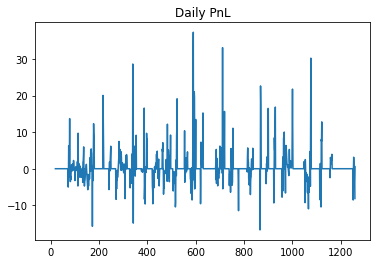

In [30]:
plt.plot(results)
plt.title("Daily PnL")

Text(0.5, 1.0, 'Total PnL')

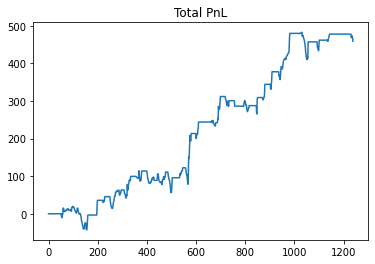

In [31]:
#Total PnL
plt.plot(results[window:].cumsum())
plt.title("Total PnL")

Text(0.5, 1.0, 'Daily Gross Returns')

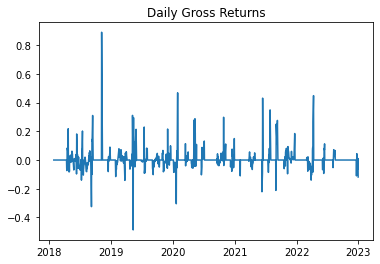

In [32]:
gross_returns=results/((y1_open+abs(dynamic_beta)*y2_open).shift(1)) #Daily PnL divided by notional value of portfolio

plt.plot(gross_returns)
plt.title("Daily Gross Returns")

Text(0.5, 1.0, 'Cumulative Gross Returns')

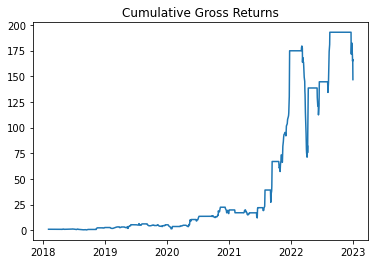

In [33]:

cum_returns=(1+gross_returns).cumprod()
plt.plot(cum_returns)
plt.title("Cumulative Gross Returns")

In [34]:
CAGR = ((cum_returns[-1])**(1/5)-1)*100
CAGR

171.22368961512277

In [35]:
#Sharpe Ratio
AnnualRate = yf.download("^TNX")["Adj Close"]
DailyRate = (1+AnnualRate/100)**(1/(365))-1

rfr = DailyRate[-1] #risk-free rate

print("Daily Sharpe: "+str((gross_returns.mean()-rfr)/gross_returns.std()))
print("Annual Sharpe: "+str(np.sqrt(252)*(gross_returns.mean()-rfr)/gross_returns.std()))

[*********************100%***********************]  1 of 1 completed
Daily Sharpe: 0.09028654578532379
Annual Sharpe: 1.4332544812980816


In [36]:
print(gross_returns.mean())
print(gross_returns.std())

0.005882178952246903
0.06386609062046311


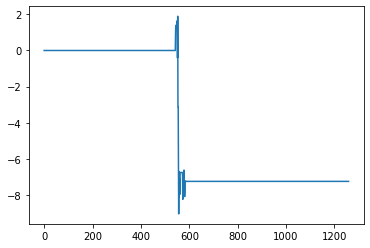

In [37]:
open_spread_kf = y1_open-beta_kf*y2_open
results_kf=Backtester(Signal_KF(error), open_spread_kf)
#Total PnL
plt.plot(results_kf.cumsum())
